# Final Notebook

## Table of Contents
* [***Introduction***](#Introduction)
* [***Package Importing***](#Package-Importing)
* [***Data Importing***](#Data-Importing)   (links to the data sources below.)
     * [Box Office Mojo](https://www.boxofficemojo.com/)
     * [IMDB](https://www.imdb.com/)
     * [Rotten Tomatoes](https://www.rottentomatoes.com/)
     * [TheMovieDB](https://www.themoviedb.org/)
     * [The Numbers](https://www.the-numbers.com/)
* [***Data Cleaning***](#Data-Cleaning)
    * [***Budget vs. Revenue Data Cleaning***](#Budget-vs.-Revenue-Data-Cleaning)
* [***Budget and Revenue Statistical Analysis***](#Budget-and-Revenue-Statistical-Analysis)
* [***Top Studios and their Budgets***](#Top-Studios-and-their-Budgets)
* [***Conclusion***](#Conclusion)


## Introduction

This cell will be used to give a little intro.

#### Package Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import sqlite3 

## Data Importing
* import all of the available data for project

In [2]:
conn = sqlite3.connect('zippedData/im.db')
imdb_movie_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)
imdb_movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings", conn)
bom_movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tmdb_movies = tmdb_movies.drop('Unnamed: 0', axis = 1)                     #remove unneccesary column
tn_movies_budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
rt_movies_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep = '\t')
rt_movies_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep = '\t', encoding='latin')

## Data Cleaning

### Budget vs. Revenue Data Cleaning

In the following cell, we add new columns named "production_budgetINT", "domestic_grossINT", and "worldwide_grossINT" to the *The Numbers* dataset. These are the columns "production_budget", "domestic_gross", and "worldwide_gross" converted from strings into integers.  We then divide all of those columns by a million and remove all movies with a worldwide gross of 0.

In [3]:
movies_budget = tn_movies_budget 

# creates a production column int column
production_budget = [] 

for budget in movies_budget['production_budget']:
    budget = int(budget[1:].replace(",", ""))
    production_budget.append(budget)
    
movies_budget['production_budgetINT'] = production_budget

# creates a domestic gross int column
domestic_gross = [] 

for gross in movies_budget['domestic_gross']:
    gross = int(gross[1:].replace(",", ""))
    domestic_gross.append(gross)
    
movies_budget['domestic_grossINT'] = domestic_gross

# creates a worldwide gross int column
worldwide_gross = [] 

for gross in movies_budget['worldwide_gross']:
    gross = int(gross[1:].replace(",", ""))
    worldwide_gross.append(gross)
    
movies_budget['worldwide_grossINT'] = worldwide_gross

#removes worldwide budgets of 0
movies_budget = movies_budget[movies_budget.worldwide_grossINT > 0]



#divide each budget by one million
movies_budget[['production_budgetINT', 'worldwide_grossINT', 'domestic_grossINT']] = movies_budget[['production_budgetINT', 'worldwide_grossINT', 'domestic_grossINT']].mul(1/1000000)

In [4]:
pd.to_datetime(movies_budget['release_date']).sort_values().tail()

2      2019-06-07
580    2019-06-07
1997   2019-06-14
341    2019-06-14
1538   2019-06-21
Name: release_date, dtype: datetime64[ns]

### Top Studios' Budgets Data Cleaning

In the cell below, we inner join the *The Numbers* budget dataframe and the *Box Office Mojo* movie gross dataframe on the movie titles. We name this new dataframe "movie_studio_budget." We then drop the one null value and combine the duplicate Warner Brothers studio observations.

In [5]:
movie_gross = bom_movie_gross

#inner join two datasets
movie_studio_budget = movies_budget.merge(movie_gross, how = 'inner', left_on = 'movie', right_on = 'title')
movie_studio_budget = movie_studio_budget[['release_date', 'movie', 'studio','production_budgetINT','worldwide_grossINT']]
#make release date datetime
movie_studio_budget['release_date'] = pd.to_datetime(movie_studio_budget['release_date'])
#drop one null studio row
movie_studio_budget = movie_studio_budget.dropna()
#make new variable called studio to edit studio names
studios = movie_studio_budget['studio']

#rename studios that are the same with different names in the dataset
studios[studios.str.contains('WB')] = 'WB'


# merge the studio variable back into dataframe
movie_studio_budget['studio'] = studios

In [ ]:
Remember to talk about the cells below

In [12]:
#isolate top 10 studios by their average movie budget and worldwide gross, sort by worldwide gross
top_studios = movie_studio_budget[['studio', 'production_budgetINT', 'worldwide_grossINT']].groupby(['studio']).mean()
top_studios = top_studios.sort_values(by = 'worldwide_grossINT', ascending = False).reset_index().head(10)

In [14]:
#isolate top 10 studios by their total budget and revenues
top_studios_total = movie_studio_budget[['studio', 'production_budgetINT', 'worldwide_grossINT']].groupby(['studio']).sum()
top_studios_total = top_studios_total.sort_values(by = 'worldwide_grossINT', ascending = False).reset_index().head(10)

## Budget and Revenue Statistical Analysis

In this section, we will perform a statistical analysis of the relationship between production budget and worldwide gross. For our analysis, we run a simple linear regression with worldwide gross as our dependent variable and production budget as our independent variable.

In the two plots below, we have the distributions for production budget and worldwide gross, respectively. Both of the distributions are skewed to the right, which is confirmed by our rejection of the null hypothesis in our normal tests. Given the fact that we will be performing a regression using OLS, the classical linear modeling assumptions allow us to generally relax the normality assumption when we have many observations, meaning we do not transform the data.

<AxesSubplot:xlabel='Production Budget (USD)', ylabel='Density'>

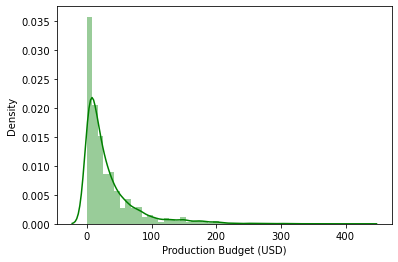

In [6]:
#plot distribution
x = pd.Series(movies_budget['production_budgetINT'], name = "Production Budget (USD)")
sns.distplot(x, color = "green")

<AxesSubplot:xlabel='Worldwide Gross (USD)', ylabel='Density'>

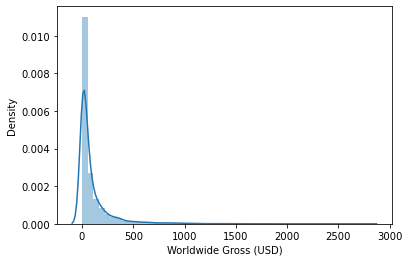

In [7]:
#plot distribution
x = pd.Series(movies_budget['worldwide_grossINT'], name = "Worldwide Gross (USD)")
sns.distplot(x)

Test for if the production budget is normally distributed. A p-value less than 0.05 rejects the null hypothesis that the data is normally distributed:

In [8]:
#test for normality
st.normaltest(movies_budget['production_budgetINT'])

NormaltestResult(statistic=3117.059393788194, pvalue=0.0)

Test for if worldwide gross is normally distributed. A p-value less than 0.05 rejects the null hypothesis that the data is normally distributed:

In [9]:
#test for normality
st.normaltest(movies_budget['worldwide_grossINT'])

NormaltestResult(statistic=4983.028689614257, pvalue=0.0)

Below we plot a scatter of Production Budget and Worldwide Gross for all movies in the movies_budget dataset and apply a line of best fit. There is a positive correlation between budget and gross, suggesting that an increase in production budget is associated with an increase in worldwide gross. However, we also see below the line of best fit that there are a few points that seem to be following a trend that would suggest diminishing returns of production budget.

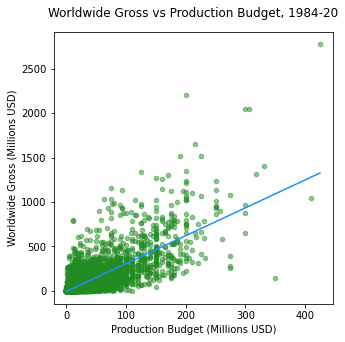

In [10]:
#plot scatterplot of budget and revenue to show relationship between the two
fig = plt.subplots(figsize=(5, 5))
x = movies_budget['production_budgetINT']
 
y = movies_budget['worldwide_grossINT']

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.title('Worldwide Gross vs Production Budget, 1984-20', pad = 15)

plt.xlabel('Production Budget (Millions USD)')
plt.ylabel('Worldwide Gross (Millions USD)')

plt.scatter(x, y, c ="forestgreen", alpha = .5, s = 20)
plt.plot(x, p(x), color = "dodgerblue")

We perform a Simple Linear Regression, regressing production budget on worldwide gross to learn more about the relationship. Some important characteristics provided in the regression output table are the R^2 value and the coefficient with its corresponding p-value.

In [11]:
lm = sm.OLS.from_formula('worldwide_grossINT ~ production_budgetINT',data = movies_budget)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     worldwide_grossINT   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     6793.
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:49:44   Log-Likelihood:                -33567.
No. Observations:                5415   AIC:                         6.714e+04
Df Residuals:                    5413   BIC:                         6.715e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -6.9150 

The coefficient from our simple linear regression suggests that an increase in 1 dollar in production budget is associated with an increase in 3.14 dollars in worldwide gross, statistically signficant at all reasonable levels. 

The R-squared, which is a measure of "goodness of fit" is 0.557. This means that production budget explains 55.7% of the sample variation of worldwide gross. 

Given our time constraints and the scope of this project, we were unable to make a more accurate and complex model. Our simple linear regression has the problem of omitted variable bias and we did not test for other issues such as heteroskedasticity. However, our Simple Linear Regression is sufficient when looking for a general picture of the relationship between budget and revenue. 

## Top Studios and their Budgets

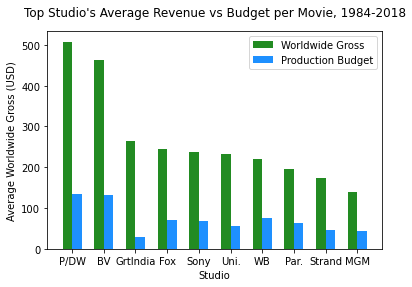

In [13]:
w=0.3
x = list(top_studios['studio'])
worldwide_gross = list(top_studios['worldwide_grossINT'])
production_budget = list(top_studios['production_budgetINT'])

bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]

plt.bar(bar1,worldwide_gross,w,label='Worldwide Gross', color = 'forestgreen')
plt.bar(bar2,production_budget,w,label='Production Budget', color = 'dodgerblue')
plt.title("Top Studio's Average Revenue vs Budget per Movie, 1984-2018", pad = 15)
plt.xticks(bar1+w/2,x)
plt.xlabel('Studio')
plt.ylabel('Average Worldwide Gross (USD)')
plt.legend()

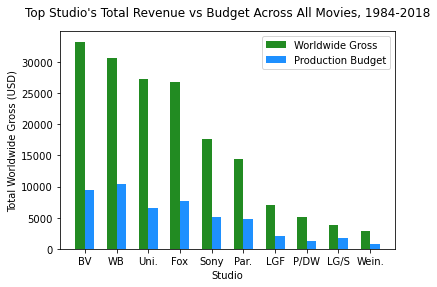

In [15]:
w=0.3
x = list(top_studios_total['studio'])
worldwide_gross = list(top_studios_total['worldwide_grossINT'])
production_budget = list(top_studios_total['production_budgetINT'])

bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]

plt.bar(bar1,(worldwide_gross),w,label='Worldwide Gross', color = 'forestgreen')
plt.bar(bar2,(production_budget),w,label='Production Budget', color = 'dodgerblue')
plt.title("Top Studio's Total Revenue vs Budget Across All Movies, 1984-2018", pad = 15)
plt.xticks(bar1+w/2,x)
plt.xlabel('Studio')
plt.ylabel('Total Worldwide Gross (USD)')
plt.legend()

We found there is a significant correlation between budget and revenue, suggesting that an increase in production budget is associated with an increase in gross revenue. However, our linear model doesn't take into account what looks to be diminishing returns to increasing production budget. It looks like the diminishing returns begin between 200,000,000 USD and 250,000,000 USD. Looking at other studios, our top competitors specifically, we can see that they spend between 43,000,000 USD and 130,000,000 USD in their production budget per movie.

## Recommendation #3

Taking into account the typical budgets of competitors and the positive relationship between production budget and worldwide gross, that also looks to have the possibility of diminishing returns, we recommend that Computing Vision keeps their movie budgets greater than 43,000,000 USD and less than 200,000,000 USD.

## Conclusion

This cell will be used to give a little conclusion.